# Realistic Navier-Stokes problem on holed domain

We consider the unsteady Navier-Stokes problem defined by the following set of differential equations: 

$$
\begin{cases}
  \frac{\partial \boldsymbol{u}}{\partial t} +
  ({\boldsymbol{u}}\cdot\boldsymbol{\nabla})\ \boldsymbol{u}
  -\dfrac{1}{\text{Re}}\boldsymbol{\Delta} \boldsymbol{u} + \boldsymbol{\nabla} p = 0, 
  \qquad&\text{in }\Omega\times I, \\
  \boldsymbol{\nabla} \cdot \boldsymbol{u} = 0, 
  \qquad &\text{in }\Omega\times I, \\
  \boldsymbol{u} = (1-y^2) \boldsymbol{i}, \qquad&\text{on }(\Gamma_{\text{in}} := \{x= -1,\, -1\le y \le 1 \})\times I, \\
  \left(\dfrac{1}{\text{Re}} \boldsymbol{\nabla} \boldsymbol{u} - pI\right) \boldsymbol{n} = 0, \qquad&\text{on }(\Gamma_{\text{out}} := \{x=4,\, -1\le y \le 1\})\times I, \\
  \boldsymbol{u} = \boldsymbol{0}, \qquad&\text{on }\partial\Omega \backslash (\Gamma_{\text{in}}\cup\Gamma_{\text{out}}) \times I, \\
  \boldsymbol{u}(\cdot,t=0) = \boldsymbol{0}, &\text{in }\Omega,
\end{cases}
$$

where the Reynolds number $\text{Re}$ is equal to $200$, the time interval is $I=(0,40)$, and the spacial domain $\Omega$ is described in the following figure.

![alt text](https://drive.google.com/uc?export=view&id=190IgTTTbGtbyWKwFfemQlQWOAOAdbNh-)

The boundary conditions express:
*   no-slip boundary conditions enforced on the lateral boundary of the pipe and on the boundary of the obstacle;

*   a parabolic profile of velocity enforced on the inlet boundary $\Gamma_{\text{in}}$;

*   homogeneous Neumann boundary condition enforced on the outlet boundary $\Gamma_{\text{out}}$.

## Numerical approximation with FEniCS

In [1]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from fenics import *
import matplotlib.pyplot as plt
import numpy as np

# we also import the module mshr for advanced mesh generation
from mshr import *

### Examples of mesh generation with mshr

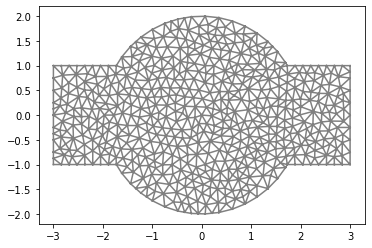

In [2]:
# Example 1
circle = Circle(Point(0.0, 0.0), 2)
box = Rectangle(Point(-3.0, -1.0), Point(3.0, 1.0))
geometry = box + circle

n = 20
mesh = generate_mesh(geometry, n)
plot(mesh)

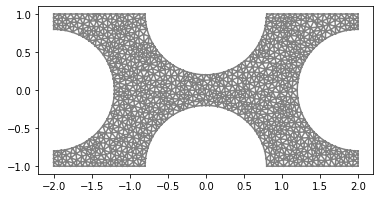

In [3]:
# Example 2
circle1 = Circle(Point(0.0, 1.0), 0.8)
circle2 = Circle(Point(0.0, -1.0), 0.8)
circle3 = Circle(Point(-2.0, 0.0), 0.8)
circle4 = Circle(Point(2.0, 0.0), 0.8)
box = Rectangle(Point(-2.0, -1.0), Point(2.0, 1.0))
geometry = box - circle1 - circle2 - circle3 - circle4

n = 40
mesh = generate_mesh(geometry, n)
plot(mesh)

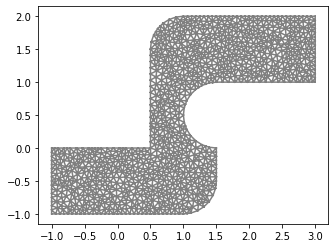

In [4]:
# Example 3
circle1 = Circle(Point(1.0, -0.5), 0.5)
circle2 = Circle(Point(1.0, 1.5), 0.5)
circle3 = Circle(Point(1.5, 0.5), 0.5)
box1 = Rectangle(Point(-1.0, -1.0), Point(1.0, 0.0))
box2 = Rectangle(Point(0.5, -0.5), Point(1.5, 1.5))
box3 = Rectangle(Point(1.0, 1.0), Point(3.0, 2.0))
geometry = box1 + circle1 + box2 + circle2 + box3 - circle3

n = 40
mesh = generate_mesh(geometry, n)
plot(mesh)

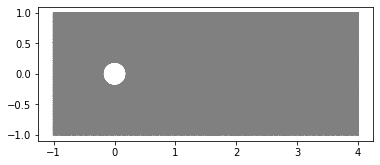

In [5]:
# Example 4
hole = Circle(Point(0.0, 0.0), 0.2)
box = Rectangle(Point(-1.0, -1.0), Point(4.0, 1.0))
geometry = box - hole

n = 120
mesh = generate_mesh(geometry, n)
plot(mesh)

### Solution of the Navier-Stokes problem

Discretize the problem using the stable pair of spaces $\mathbb{P}^2-\mathbb{P}^1$ and the backward Euler semi-implicit scheme.

In [ ]:
# 1. mesh generation
hole = Circle(Point(0.0, 0.0), 0.2)
box = Rectangle(Point(-1.0, -1.0), Point(4.0, 1.0))
geometry = box - hole

n = 120
mesh = generate_mesh(geometry, n)

# 2. finite element space and BCs
degree = 1
V = VectorElement('CG', mesh.ufl_cell(), degree+1)
Q = FiniteElement('CG', mesh.ufl_cell(), degree)
X = FunctionSpace(mesh, V*Q)

def inflow(x, on_boundary):
  return on_boundary and near(x[0], -1.0)

def rigid_wall(x, on_boundary):
  return on_boundary and not near(x[0], -1.0) and not near(x[0], 4.0)

u_inflow = Expression(('1 - x[1] * x[1]', '0'), degree=2)

bcs = [DirichletBC(X.sub(0), u_inflow, inflow),
       DirichletBC(X.sub(0), Constant((0.0, 0.0)), rigid_wall)]

After introducing the FE spaces and defining the boundary conditions, we proceed with the formulation of the discrete problem corresponding to the semi-implicit time-advancing scheme (with a time-step $\delta t = 0.5$).

In [ ]:
# 3. problem definition
u, p = TrialFunctions(X)
v, q = TestFunctions(X)

x_old = Function(X)
u_old, p_old = split(x_old)

Re = Constant(200)
f = Constant((0.0, 0.0))
time = 0.0
dt = 0.5

a = (dot(u, v)/Constant(dt) + dot(grad(u)*u_old, v) + inner(grad(u), grad(v))/Re - p*div(v) - div(u)*q) * dx
L = (dot(u_old, v)/Constant(dt) + dot(f, v)) * dx

#4. solve (advance in time)
x = Function(X)
u, p = x.split()
u.rename('velocity', 'velocity')
p.rename('pressure', 'pressure')

ufile = File('velocity.pvd')
pfile = File('pressure.pvd')

ufile << (u, time)
pfile << (p, time)

while time < 40.0:
  time += dt
  f.t = time

  print('solving step {}'.format(time))
  x_old.assign(x)
  solve(a == L, x, bcs)

  u, p = x.split()
  u.rename('velocity', 'velocity')
  p.rename('pressure', 'pressure')
  ufile << (u, time)
  pfile << (p, time)

## Stabilized methods for large values of $\text{Re}$

Discretization using the stable **MINI element** and the backward Euler **semi-implicit scheme**. In this way, we have a method which is first order convergent in both space and time.

We consider the cases $\text{Re} = 2000$ and $\text{Re} = 20000$.

In [ ]:
# 1. mesh generation
hole = Circle(Point(0.0, 0.0), 0.2)
box = Rectangle(Point(-1.0, -1.0), Point(4.0, 1.0))
geometry = box - hole

n = 120
mesh = generate_mesh(geometry, n)

# 2. finite element space and BCs
Q = FiniteElement('CG', mesh.ufl_cell(), 1)
B = FiniteElement("Bubble", mesh.ufl_cell(), mesh.topology().dim() + 1)
V = VectorElement(NodalEnrichedElement(Q, B))
X = FunctionSpace(mesh, V * Q)

def inflow(x, on_boundary):
  return on_boundary and near(x[0], -1.0)

def rigid_wall(x, on_boundary):
  return on_boundary and not near(x[0], -1.0) and not near(x[0], 4.0)

u_inflow = Expression(('1 - x[1] * x[1]', '0'), degree=2)

bcs = [DirichletBC(X.sub(0), u_inflow, inflow),
       DirichletBC(X.sub(0), Constant((0.0, 0.0)), rigid_wall)]

# 3. problem definition
u, p = TrialFunctions(X)
v, q = TestFunctions(X)

x_old = Function(X)
u_old, p_old = split(x_old)

Re = Constant(2000)
f = Constant((0.0, 0.0))
time = 0.0
dt = 0.5

a = (dot(u, v)/Constant(dt) + dot(grad(u)*u_old, v) + inner(grad(u), grad(v))/Re - p*div(v) - div(u)*q) * dx
L = (dot(u_old, v)/Constant(dt) + dot(f, v)) * dx

#4. solve (advance in time)
x = Function(X)
u, p = x.split()
u.rename('velocity', 'velocity')
p.rename('pressure', 'pressure')

ufile = File('velocity.pvd')
pfile = File('pressure.pvd')

ufile << (u, time)
pfile << (p, time)

while time < 40.0:
  time += dt
  f.t = time

  print('solving step {}'.format(time))
  x_old.assign(x)
  solve(a == L, x, bcs)

  u, p = x.split()
  u.rename('velocity', 'velocity')
  p.rename('pressure', 'pressure')
  ufile << (u, time)
  pfile << (p, time)

### Stabilization methods

In what follows, we consider the **Streamline diffusion**, the  **SUPG** and the **GLS** stabilization methods for the solution of the problem at each time-step. We adopt the following definition of the stabilization parameter
$$
      \delta_K = \frac{h_K}{2 ||\boldsymbol{u}||} \xi(\mathbb{P}e_K),
$$
where the local Péclet number is defined as
$$
      \mathcal{Pe}_K := \frac{||\boldsymbol{u}||h_K}{2} \text{Re},
$$
and $\xi$ is the *upwind* function
$$
      \xi(\theta) = \min{\left(1,\frac{\theta}3\right)}.
$$
Compare the approximation computed with the MINI method with respect to the solutions obtained with the stabilized schemes. Consider also the stabilized $\mathbb{P}^1-\mathbb{P}^1$ method.

In [ ]:
# 1. mesh generation
hole = Circle(Point(0.0, 0.0), 0.2)
box = Rectangle(Point(-1.0, -1.0), Point(4.0, 1.0))
geometry = box - hole

n = 120
mesh = generate_mesh(geometry, n)

# 2. finite element space and BCs
Q = FiniteElement('CG', mesh.ufl_cell(), 1)
B = FiniteElement("Bubble", mesh.ufl_cell(), mesh.topology().dim() + 1)
V = VectorElement(NodalEnrichedElement(Q, B))
X = FunctionSpace(mesh, V * Q)

def inflow(x, on_boundary):
  return on_boundary and near(x[0], -1.0)

def rigid_wall(x, on_boundary):
  return on_boundary and not near(x[0], -1.0) and not near(x[0], 4.0)

u_inflow = Expression(('1 - x[1] * x[1]', '0'), degree=2)

bcs = [DirichletBC(X.sub(0), u_inflow, inflow),
       DirichletBC(X.sub(0), Constant((0.0, 0.0)), rigid_wall)]

# 3. problem definition
u, p = TrialFunctions(X)
v, q = TestFunctions(X)

x_old = Function(X)
u_old, p_old = split(x_old)

Re = Constant(2000)
f = Constant((0.0, 0.0))
time = 0.0
dt = 0.5

a = (dot(u, v)/Constant(dt) + dot(grad(u)*u_old, v) + inner(grad(u), grad(v))/Re - p*div(v) + div(u)*q) * dx
L = (dot(u_old, v)/Constant(dt) + dot(f, v)) * dx

# stabilization parameter
h = CellDiameter(mesh)
anorm = sqrt(dot(u_old, u_old))
tau_K = 0.5 * h / conditional(anorm * h * Re > 6, anorm, 6 / h / Re)

# choice of stabilization method
eta = 1   # 0 for streamiline diff, 1 for strongly consistent methods
rho = 0   # 0 for SUPG, 1 for GLS

if eta == 1:
  A = lambda u, p: u/Constant(dt) + (grad(u) * u_old) - div(grad(u))/Re + grad(p)
  A_S = lambda u, p: u/Constant(dt) - div(grad(u))/Re - 0.5 * div(u_old) * u
  A_SS = lambda u, p: (grad(u) * u_old) + grad(p) + 0.5 * div(u_old) * u
elif eta == 0:
  rho = 0
  A = lambda u, p: (grad(u) * u_old) + grad(p)
  A_SS = lambda u, p: (grad(u) * u_old) + grad(p)
  
B_SS = lambda u: div(u) # (B=B_SS) 

a += tau_K * (dot(A(u,p), A_SS(v, q) + rho*A_S(v,q)) + B_SS(u) * B_SS(v)) * dx
L += tau_K * Constant(eta) * (dot(u_old/Constant(dt) + f, A_SS(v, q) + rho*A_S(v,q))) * dx

#4. solve (advance in time)
x = Function(X)
u, p = x.split()
u.rename('velocity', 'velocity')
p.rename('pressure', 'pressure')

ufile = File('velocity_stab.pvd')
pfile = File('pressure_stab.pvd')

ufile << (u, time)
pfile << (p, time)

while time < 40.0:
  time += dt
  f.t = time

  print('solving step {}'.format(time))
  x_old.assign(x)
  solve(a == L, x, bcs)

  u, p = x.split()
  u.rename('velocity', 'velocity')
  p.rename('pressure', 'pressure')
  ufile << (u, time)
  pfile << (p, time)

solving step 0.5
solving step 1.0
solving step 1.5
solving step 2.0
solving step 2.5
solving step 3.0
solving step 3.5
solving step 4.0
solving step 4.5
solving step 5.0
solving step 5.5
solving step 6.0
solving step 6.5
solving step 7.0
solving step 7.5
solving step 8.0
solving step 8.5
solving step 9.0
solving step 9.5
solving step 10.0
solving step 10.5
solving step 11.0
solving step 11.5
solving step 12.0
solving step 12.5
solving step 13.0
solving step 13.5
solving step 14.0
solving step 14.5
solving step 15.0
solving step 15.5
solving step 16.0
solving step 16.5
solving step 17.0
solving step 17.5
solving step 18.0
solving step 18.5
solving step 19.0
solving step 19.5
solving step 20.0
solving step 20.5
solving step 21.0
solving step 21.5
solving step 22.0
solving step 22.5
solving step 23.0
solving step 23.5
solving step 24.0
solving step 24.5
solving step 25.0
solving step 25.5
solving step 26.0
solving step 26.5
solving step 27.0
solving step 27.5
solving step 28.0
solving ste